In [1]:
import warnings
warnings.filterwarnings("ignore", message="A NumPy version >=")
warnings.filterwarnings("ignore", message="FutureWarning:")
warnings.filterwarnings("ignore", message="UserWarning:")
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [2]:
#Backbone of data organization
import pandas as pd
import numpy as np
#Machine learning tools from SciKit-Learn
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, mean_squared_error, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import VotingClassifier, BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
#Machine learning tools from Statsmodels
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
#Statistical Testing
from scipy import stats
#Visualization tools
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'iframe'
#Helps keep track of training times
import time

This data was taken from SimplyAnalytics, which has data on a variety of subjects for most US counties, including Puerto Rico. Data was downloaded from SimplyAnalytics as shapefiles, before being put through ArcGIS online to be exported as .csv files. As SimplyAnalytics only allows you to download ten features at the county level per shapefile, five shapefiles had to be converted to .csv format and then joined by spatial ID.

Data.csv contains an abundance of data that I deemed relevant to rates of depression in the US, including crime rates, epidemiology, health behaviors, and basic demographic statistics, among others. Depression itself is recorded via the "% population, with depression" column. This refers to the percent of adults aged 18 or more years who have reported depressive symptoms, and is missing for all counties in Florida and Puerto Rico.

In order to generate a rough estimate for depression in these counties, I utilize a variety of machine learning models trained on the abundance of data on other areas for each county.

In [3]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,spatial_id,name,"% population, lacking health insurance","% population, non-citizens","% population, without internet access","% population, without high-school education","% population, whose commute is 90+ minutes",Median income,"% population, male",...,"% population, cognitive disability","% population, individual living disability","average, self-reported mental health","average, self-reported physical health","% population, binge drinking","% population, smoking","% population, without physical activity","% population, less than 7 hours of sleep","% population, in poverty","% population, with depression"
0,0,51610,"Falls Church city, VA",3.8285,4.2811,1.6937,3.6473,1.3051,158005.583721,49.0126,...,7.1765,3.7250,11.5805,6.9313,18.4176,7.9498,13.5138,30.2433,2.0871,19.8510
1,1,51678,"Lexington city, VA",7.6005,3.3659,6.0019,4.5010,0.7884,63925.395035,60.4235,...,15.8981,8.1917,19.5995,9.9059,19.0079,12.5000,21.1924,30.8101,26.2336,24.5904
2,2,72033,"Cataño Municipio, PR",0.0000,0.0000,52.0332,24.0707,5.0907,19630.975519,46.9006,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,45.0673,0.0000
3,3,51685,"Manassas Park city, VA",12.1139,15.3833,4.0519,24.1794,10.5785,90256.312061,51.6286,...,13.2299,6.5991,16.4425,9.7563,18.7213,15.1132,23.1366,35.5040,2.8343,20.9052
4,4,51580,"Covington city, VA",8.4537,0.0351,3.2832,11.8706,1.4455,42783.823622,45.1805,...,14.7383,9.3237,17.0748,13.5251,15.2101,19.3440,27.4994,35.5650,12.9587,23.4779


In [4]:
columns = (list(data.columns))
columns = sorted(columns[3:-1])

This interactive scatterplot displays data for all countries with recorded data for both depression and a potential independent variable. This variable cna be switched out for others using the dropdown menu above the plot. Additionally, individual counties, shown via the points on the scatterplot, can be hovered over in order to display their name and exact statistics for depression and the other variable. A regresssion line is also included for each graph, which displays the p-value, R-squared, and slope of a bivariate linear regression among both variables. A green line means that the p-value is above 5%, a red line means it is not.

In [5]:
def interactive_scatter(x_var):
    viewdata = data[data['% population, lacking health insurance'] != 0]
    viewdata = viewdata[viewdata[x_var] != 0]
    xv= viewdata[x_var]
    yv= viewdata['% population, with depression']
    xvwithcons = sm.add_constant(xv)
    model = sm.OLS(yv, xvwithcons).fit()
    y_pred = model.predict(xvwithcons)
    trace = go.Scatter(
        x=xv,
        y=yv,
        text = viewdata['name'],
        mode='markers',
        marker=dict(size=5, color='black'),
        name='American county data'
        )
    if list(model.pvalues)[1] <= .05:
        trendline = go.Scatter(
            x=xv,
            y=y_pred,
            mode='lines',
            text=f"P-value: {model.pvalues.iloc[1]:.4f}, R2: {model.rsquared:.4f}, Slope: {model.params.iloc[1]:.4f}", 
            line=dict(color='green'),
            name='OLS trendline'
            )
    else:
        trendline = go.Scatter(
            x=xv,
            y=y_pred,
            mode='lines',
            text=f"P-value: {model.pvalues.iloc[1]:.4f}, R2: {model.rsquared:.4f}, Slope: {model.params.iloc[1]:.4f}",
            line=dict(color='red'),
            name='OLS trendline'
            )
    layout = go.Layout(
        title=f'Scatterplot for {x_var} vs depression',
        xaxis=dict(title=f'{x_var}'),
        yaxis=dict(title='depression', range=[10, 35]),
        )
    fig = go.Figure(data=[trace, trendline], layout=layout)
    fig.show()
    
custslider = widgets.Dropdown(
    options=columns, 
    value='% population, lacking health insurance',
    description='x axis:',
    continuous_update=False,
    style={'description_width': '200'},
    layout=widgets.Layout(width='500px')
    )

interact(interactive_scatter, x_var=custslider)

interactive(children=(Dropdown(description='x axis:', index=20, layout=Layout(width='500px'), options=('# case…

<function __main__.interactive_scatter(x_var)>

Given the low predictive power of single variables, and challenges of utilizing multiple linear regression with a high number of independent variables, predicting an exact number for depression in FL and PR presents a challenging task. It would instead be easier to split the depression statistic into multiple percentile ranges, thereby treating depression as a categorical variable, so that tools such as logistic regression and linear discriminant analysis can be used. The goal being to generate a simple estimate of depression in these states, a categorical variable could perform just as well as a numerical variable. At any rate, our prediction is only meaningful when compared against the data for other counties, which this approach will accomplish.

The "analyzedata" dataset is equivalent to the "data" dataset, save for the fact that the column names have been edited to be useable for machine learning. By converting the column names to snake_case, a multitude of errors can be avoided.

In [6]:
analyzedata = pd.read_csv("analyzedata.csv")

In [7]:
analyzedata.head()

,Unnamed: 0,spatial_id,name,perc_population_lacking_health_insurance,perc_population_noncitizens,perc_population_without_internet_access,perc_population_without_highschool_education,perc_population_whose_commute_is_90_minutes,Median_income,perc_population_male,...,perc_population_cognitive_disability,perc_population_individual_living_disability,average_selfreported_mental_health,average_selfreported_physical_health,perc_population_binge_drinking,perc_population_smoking,perc_population_without_physical_activity,perc_population_less_than_7_hours_of_sleep,perc_population_in_poverty,perc_population_with_depression
0,0,51610,"Falls Church city, VA",3.8285,4.2811,1.6937,3.6473,1.3051,158005.583721,49.0126,...,7.1765,3.7250,11.5805,6.9313,18.4176,7.9498,13.5138,30.2433,2.0871,19.8510
1,1,51678,"Lexington city, VA",7.6005,3.3659,6.0019,4.5010,0.7884,63925.395035,60.4235,...,15.8981,8.1917,19.5995,9.9059,19.0079,12.5000,21.1924,30.8101,26.2336,24.5904
2,2,72033,"Cataño Municipio, PR",0.0000,0.0000,52.0332,24.0707,5.0907,19630.975519,46.9006,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,45.0673,0.0000
3,3,51685,"Manassas Park city, VA",12.1139,15.3833,4.0519,24.1794,10.5785,90256.312061,51.6286,...,13.2299,6.5991,16.4425,9.7563,18.7213,15.1132,23.1366,35.5040,2.8343,20.9052
4,4,51580,"Covington city, VA",8.4537,0.0351,3.2832,11.8706,1.4455,42783.823622,45.1805,...,14.7383,9.3237,17.0748,13.5251,15.2101,19.3440,27.4994,35.5650,12.9587,23.4779


The analyzedata dataset is split into two kinds - miss_data, which records information for the counties in FL and PR, and precomp_data, which records information for all the other counties, and whicch will be used for training and testing the models.

In [8]:
miss_data = analyzedata[analyzedata['perc_population_with_depression'] == 0]

In [9]:
precomp_data = analyzedata[analyzedata['perc_population_with_depression'] != 0]

The quartileranges() function assesses what each of the categories we divide our depression data into actually mean. In this case, since we are using three categories - Q1, counties with the lowest depression rates, Q2, counties with middling depression rates, and Q3, counties with high depression rates - the function shows us the numerical equivalents of what those categories mean.

In [10]:
def quartileranges(x):
    quartiles = []
    for i in range(1, x + 1):
        quartiles.append("Q" + str(i))
    comp_data = precomp_data.copy()
    comp_data['dep_qt'] = pd.qcut(precomp_data['perc_population_with_depression'], q=x, labels=quartiles)
    for i in quartiles:
        comp_databd = comp_data.query(f'dep_qt == "{i}"')
        print([i, comp_databd.perc_population_with_depression.min(), comp_databd.perc_population_with_depression.max()])

In [11]:
quartileranges(4)

['Q1', 12.0295, 20.9249]
['Q2', 20.9275, 22.8042]
['Q3', 22.8045, 24.979]
['Q4', 24.9818, 33.2019]


Now that we know what splitting the depression data into three categories by percentile means, we are then able to start preparing for analysis. We start by create a new dataset, "comp_data", from precomp_data, with which we finalize our three-category split.

We then separate our dependent variable, dep_qt, and drop unnecessary columns from comp_data, which become y and X for our train-test split function. Leaving 35% of our counties for testing purposes, we also set some parameters for 'C' tuning later, and standardize our independent variables.

In [12]:
comp_data = precomp_data.copy()
comp_data['dep_qt'] = pd.qcut(precomp_data['perc_population_with_depression'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [13]:
y = comp_data['dep_qt']
X = comp_data.drop(['Unnamed: 0', 'spatial_id', 'name', 'perc_population_with_depression', 'dep_qt'], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Logistic Regression

We can optimize the logistic regression in one of three ways based off of the different penalties we can assign during hyperparameteer tuning, those being l1, l2, and elasticnet, which uses both l1 and l2 penalties. Since these penalties are only compatible with certain solvers, we set each of the penalties as constant and use GridSearchCV to parse through the solvers and C values in three separate functions.

Comparing each penalty individually, the best performance for logistic regression comes from using an LBFGS solver and l2 penalty, with around 69% accuracy. This model, as does many others, does exceptionally well at predicting the most extreme quartiles, but not as well as predicting those in between, suffering roughly a 20% decrease in accuracy when predicting the second or third quartiles as opposed to predicting the first or fourth.

In [16]:
# start = time.time()
# logreg = LogisticRegression(solver = 'liblinear', penalty = 'l1',  max_iter = 100000)
# param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
# grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)
# end = time.time()
# print(f"Time elapsed: {end-start:.4f}")

In [17]:
start = time.time()
logreg = LogisticRegression(solver = 'newton-cg', penalty = 'l2',  max_iter = 100000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag']}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
end = time.time()
print(f"Time elapsed: {end-start:.4f}")

Best Hyperparameters: {'C': 1, 'solver': 'lbfgs'}
Time elapsed: 61.7365


In [18]:
# start = time.time()
# logreg = LogisticRegression(solver = 'saga', penalty = 'elasticnet',  max_iter = 100000)
# param_grid = {
#             'C': [0.01, 0.1, 1, 10, 100, 1000],
#             'l1_ratio': [0.1, 0.5, 0.7, 0.9]
# }
# grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)
# end = time.time()
# print(f"Time elapsed: {end-start:.4f}")

Accuracy: 0.6899


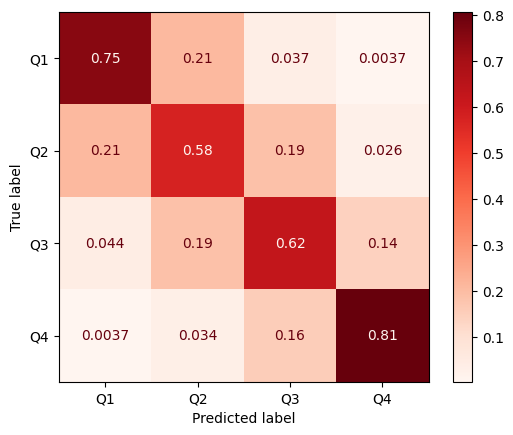

[[203  56  10   1]
 [ 56 154  50   7]
 [ 12  51 170  39]
 [  1   9  42 216]]
              precision    recall  f1-score   support

          Q1       0.75      0.75      0.75       270
          Q2       0.57      0.58      0.57       267
          Q3       0.62      0.62      0.62       272
          Q4       0.82      0.81      0.81       268

    accuracy                           0.69      1077
   macro avg       0.69      0.69      0.69      1077
weighted avg       0.69      0.69      0.69      1077



In [19]:
logregbm = grid_search.best_estimator_
y_pred = logregbm.predict(X_test)
logregacc = accuracy_score(y_pred, y_test)
print(f"Accuracy: {logregacc:.4f}")
ConfusionMatrixDisplay.from_estimator(logregbm, X_test, y_test, cmap = plt.cm.Reds, normalize = 'true')
plt.show() 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## Linear Discriminant Analysis

The Linear Discriminant Analysis (LDA) model does not do as well as the Logistic Regression, but only for predicting extreme quartiles. Performance for predicting the middle quartiles is more valuable, given that our goal is to have our collective models "vote" on their predictions, and in this regard the LDA performs roughly the same if not slightly better. 

The LDA can be optimized by solver and by shrinkage. The SVD solver, which is the most accurate in this case, is not compatible with shrinkage, so a distinction is made in the code. This model has around 67% accuracy overall.

In [20]:
start = time.time()
lda = LinearDiscriminantAnalysis()
param_grid = [
    {'solver': ['svd'], 'shrinkage': [None]},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]}
]
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
end = time.time()
print(f"Time elapsed: {end-start:.4f}")

Best Hyperparameters: {'shrinkage': None, 'solver': 'svd'}
Time elapsed: 3.1225


Accuracy: 0.6676


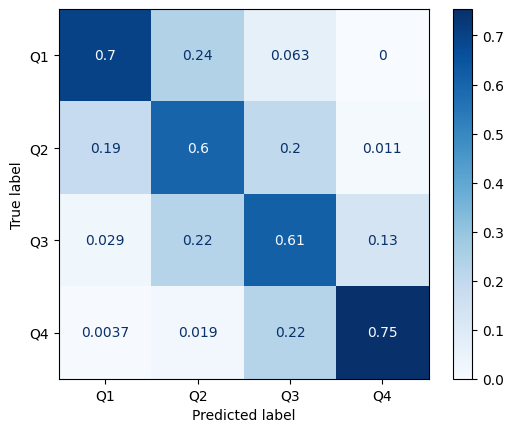

[[189  64  17   0]
 [ 50 161  53   3]
 [  8  61 167  36]
 [  1   5  60 202]]
              precision    recall  f1-score   support

          Q1       0.76      0.70      0.73       270
          Q2       0.55      0.60      0.58       267
          Q3       0.56      0.61      0.59       272
          Q4       0.84      0.75      0.79       268

    accuracy                           0.67      1077
   macro avg       0.68      0.67      0.67      1077
weighted avg       0.68      0.67      0.67      1077



In [21]:
ldabm = grid_search.best_estimator_
y_pred = ldabm.predict(X_test)
ldaacc = accuracy_score(y_pred, y_test)
print(f"Accuracy: {ldaacc:.4f}")
ConfusionMatrixDisplay.from_estimator(ldabm, X_test, y_test, cmap = plt.cm.Blues, normalize = 'true')
plt.show() 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## Gaussian Naive Bayes

The Gaussian Naive Bayes model performs the worst out of all the models at 41% accuracy and furthermore has limited room for hyperparameter tuning. It is progressively more accurate at predicting values the greater the rate of depression they correspond to, but fails to surpass the prior models' predictions in any quartiles. The reason for the model's lackluster performance may be due to the fact that many of my indpendent variables are not normally distributed, as can be seen in my interactive scatterplot.

Accuracy: 0.4132


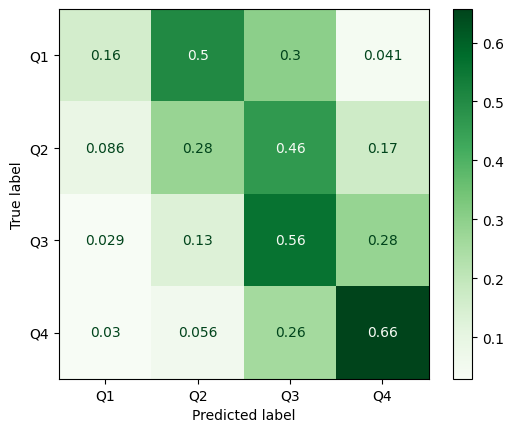

[[ 42 136  81  11]
 [ 23  75 124  45]
 [  8  35 152  77]
 [  8  15  69 176]]
              precision    recall  f1-score   support

          Q1       0.52      0.16      0.24       270
          Q2       0.29      0.28      0.28       267
          Q3       0.36      0.56      0.44       272
          Q4       0.57      0.66      0.61       268

    accuracy                           0.41      1077
   macro avg       0.43      0.41      0.39      1077
weighted avg       0.43      0.41      0.39      1077

Time elapsed: 0.3063


In [22]:
start = time.time()
NBayes = GaussianNB()
NBayes.fit(X_train, y_train)
y_pred = NBayes.predict(X_test)
NBayesacc = accuracy_score(y_pred, y_test)
print(f"Accuracy: {NBayesacc:.4f}")
ConfusionMatrixDisplay.from_estimator(NBayes, X_test, y_test, cmap = plt.cm.Greens, normalize = 'true')
plt.show()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
end = time.time()
print(f"Time elapsed: {end-start:.4f}")

## K-Nearest Neighbors Classifier

I first define the optimal K to set my K-Nearest Neighbors Classifier to using the below function and graph. For each point, K refers to the number of data points most similar to it that will be used to determine which quartile that point belongs to. In this case, K is 57 - around 5% of the 1,033 points in our testing data.

Similarly to the Logisstic Regression and LDA models, this model does well at predicting extreme quartiles but suffers in middle quartiles. In this regard, it also has a reduced accuracy of around 60%.

The optimal K is: 57


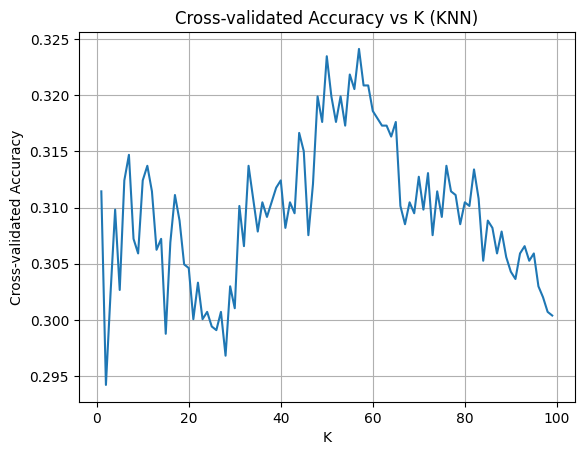

In [23]:
def optknn(X, y):
    k_values = range(1, 100)
    cv_scores = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=4, scoring='accuracy')
        cv_scores.append(scores.mean())
    optimal_k = k_values[np.argmax(cv_scores)]
    print(f"The optimal K is: {optimal_k}")
    plt.plot(k_values, cv_scores)
    plt.xlabel('K')
    plt.ylabel('Cross-validated Accuracy')
    plt.title('Cross-validated Accuracy vs K (KNN)')
    plt.grid(True)
    plt.show()
optknn(X, y)

Cross-validation scores: [0.5975    0.52      0.565     0.5625    0.5112782]
Average cross-validation score: 0.5513
Accuracy: 0.6091


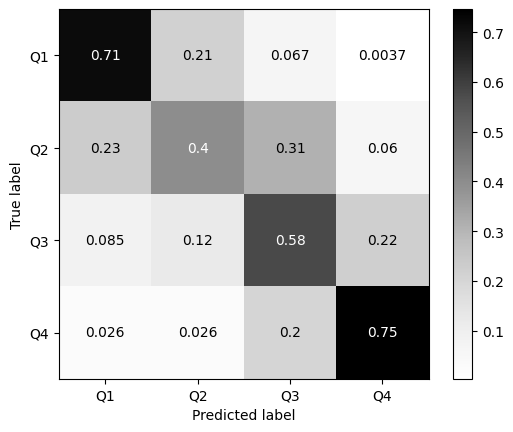

[[193  58  18   1]
 [ 62 106  83  16]
 [ 23  32 157  60]
 [  7   7  54 200]]
              precision    recall  f1-score   support

          Q1       0.68      0.71      0.70       270
          Q2       0.52      0.40      0.45       267
          Q3       0.50      0.58      0.54       272
          Q4       0.72      0.75      0.73       268

    accuracy                           0.61      1077
   macro avg       0.61      0.61      0.60      1077
weighted avg       0.61      0.61      0.60      1077

Time elapsed: 0.7250


In [24]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=57)
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print(f"Average cross-validation score: {cv_scores.mean():.4f}", )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
knnacc = accuracy_score(y_pred, y_test)
print(f"Accuracy: {knnacc:.4f}")
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap = plt.cm.Greys, normalize = 'true')
plt.show()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
end = time.time()
print(f"Time elapsed: {end-start:.4f}")

## Support Vector Classsifier

The Support Vector Classifier (SVC) has the best accuracy out of all the models thus far, at 72%. Tuning for different kernel types and C values, we use an RBF kernel and a C-value of 10. There are also more in-depth customizations for polynomial and sigmoid kernels, but factoring them in is computationally expensive, and besides, RBF is already the most accurate kernel. This model has decent accuracy for all its predictions.

In [25]:
start = time.time()
svc = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
end = time.time()
print(f"Time elapsed: {end-start:.4f}")

Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
Time elapsed: 64.6208


Accuracy: 0.7205


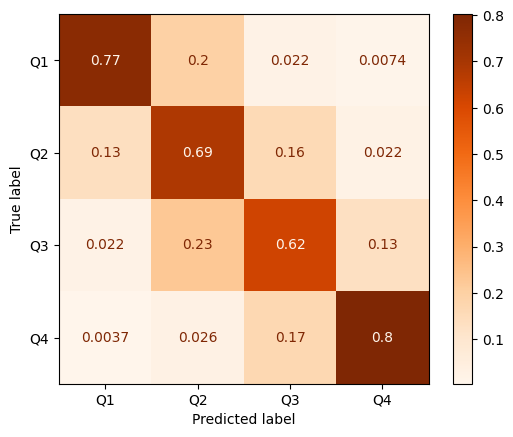

[[209  53   6   2]
 [ 36 183  42   6]
 [  6  62 169  35]
 [  1   7  45 215]]
              precision    recall  f1-score   support

          Q1       0.83      0.77      0.80       270
          Q2       0.60      0.69      0.64       267
          Q3       0.65      0.62      0.63       272
          Q4       0.83      0.80      0.82       268

    accuracy                           0.72      1077
   macro avg       0.73      0.72      0.72      1077
weighted avg       0.73      0.72      0.72      1077



In [26]:
svcbm = grid_search.best_estimator_
y_pred = svcbm.predict(X_test)
svcacc = accuracy_score(y_pred, y_test)
print(f"Accuracy: {svcacc:.4f}")
ConfusionMatrixDisplay.from_estimator(svcbm, X_test, y_test, cmap = plt.cm.Oranges, normalize = 'true')
plt.show() 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## Random Forest Classifier

In [27]:
start = time.time()
rf = RandomForestClassifier(bootstrap = False, random_state = 1)
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2']
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
end = time.time()
print(f"Time elapsed: {end-start:.4f}")

Best Hyperparameters: {'criterion': 'entropy', 'max_features': 'sqrt'}
Time elapsed: 146.1272


Accuracy: 0.6834


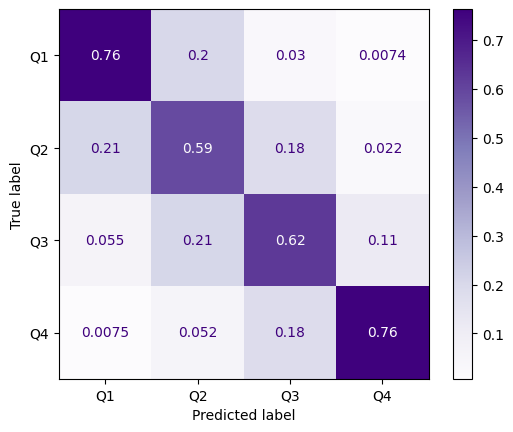

[[206  54   8   2]
 [ 55 157  49   6]
 [ 15  56 170  31]
 [  2  14  49 203]]
              precision    recall  f1-score   support

          Q1       0.74      0.76      0.75       270
          Q2       0.56      0.59      0.57       267
          Q3       0.62      0.62      0.62       272
          Q4       0.84      0.76      0.80       268

    accuracy                           0.68      1077
   macro avg       0.69      0.68      0.69      1077
weighted avg       0.69      0.68      0.69      1077



In [28]:
rfbm = grid_search.best_estimator_
y_pred = rfbm.predict(X_test)
rfacc = accuracy_score(y_pred, y_test)
print(f"Accuracy: {rfacc:.4f}")
ConfusionMatrixDisplay.from_estimator(rfbm, X_test, y_test, cmap = plt.cm.Purples, normalize = 'true')
plt.show() 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

<function matplotlib.pyplot.show(close=None, block=None)>

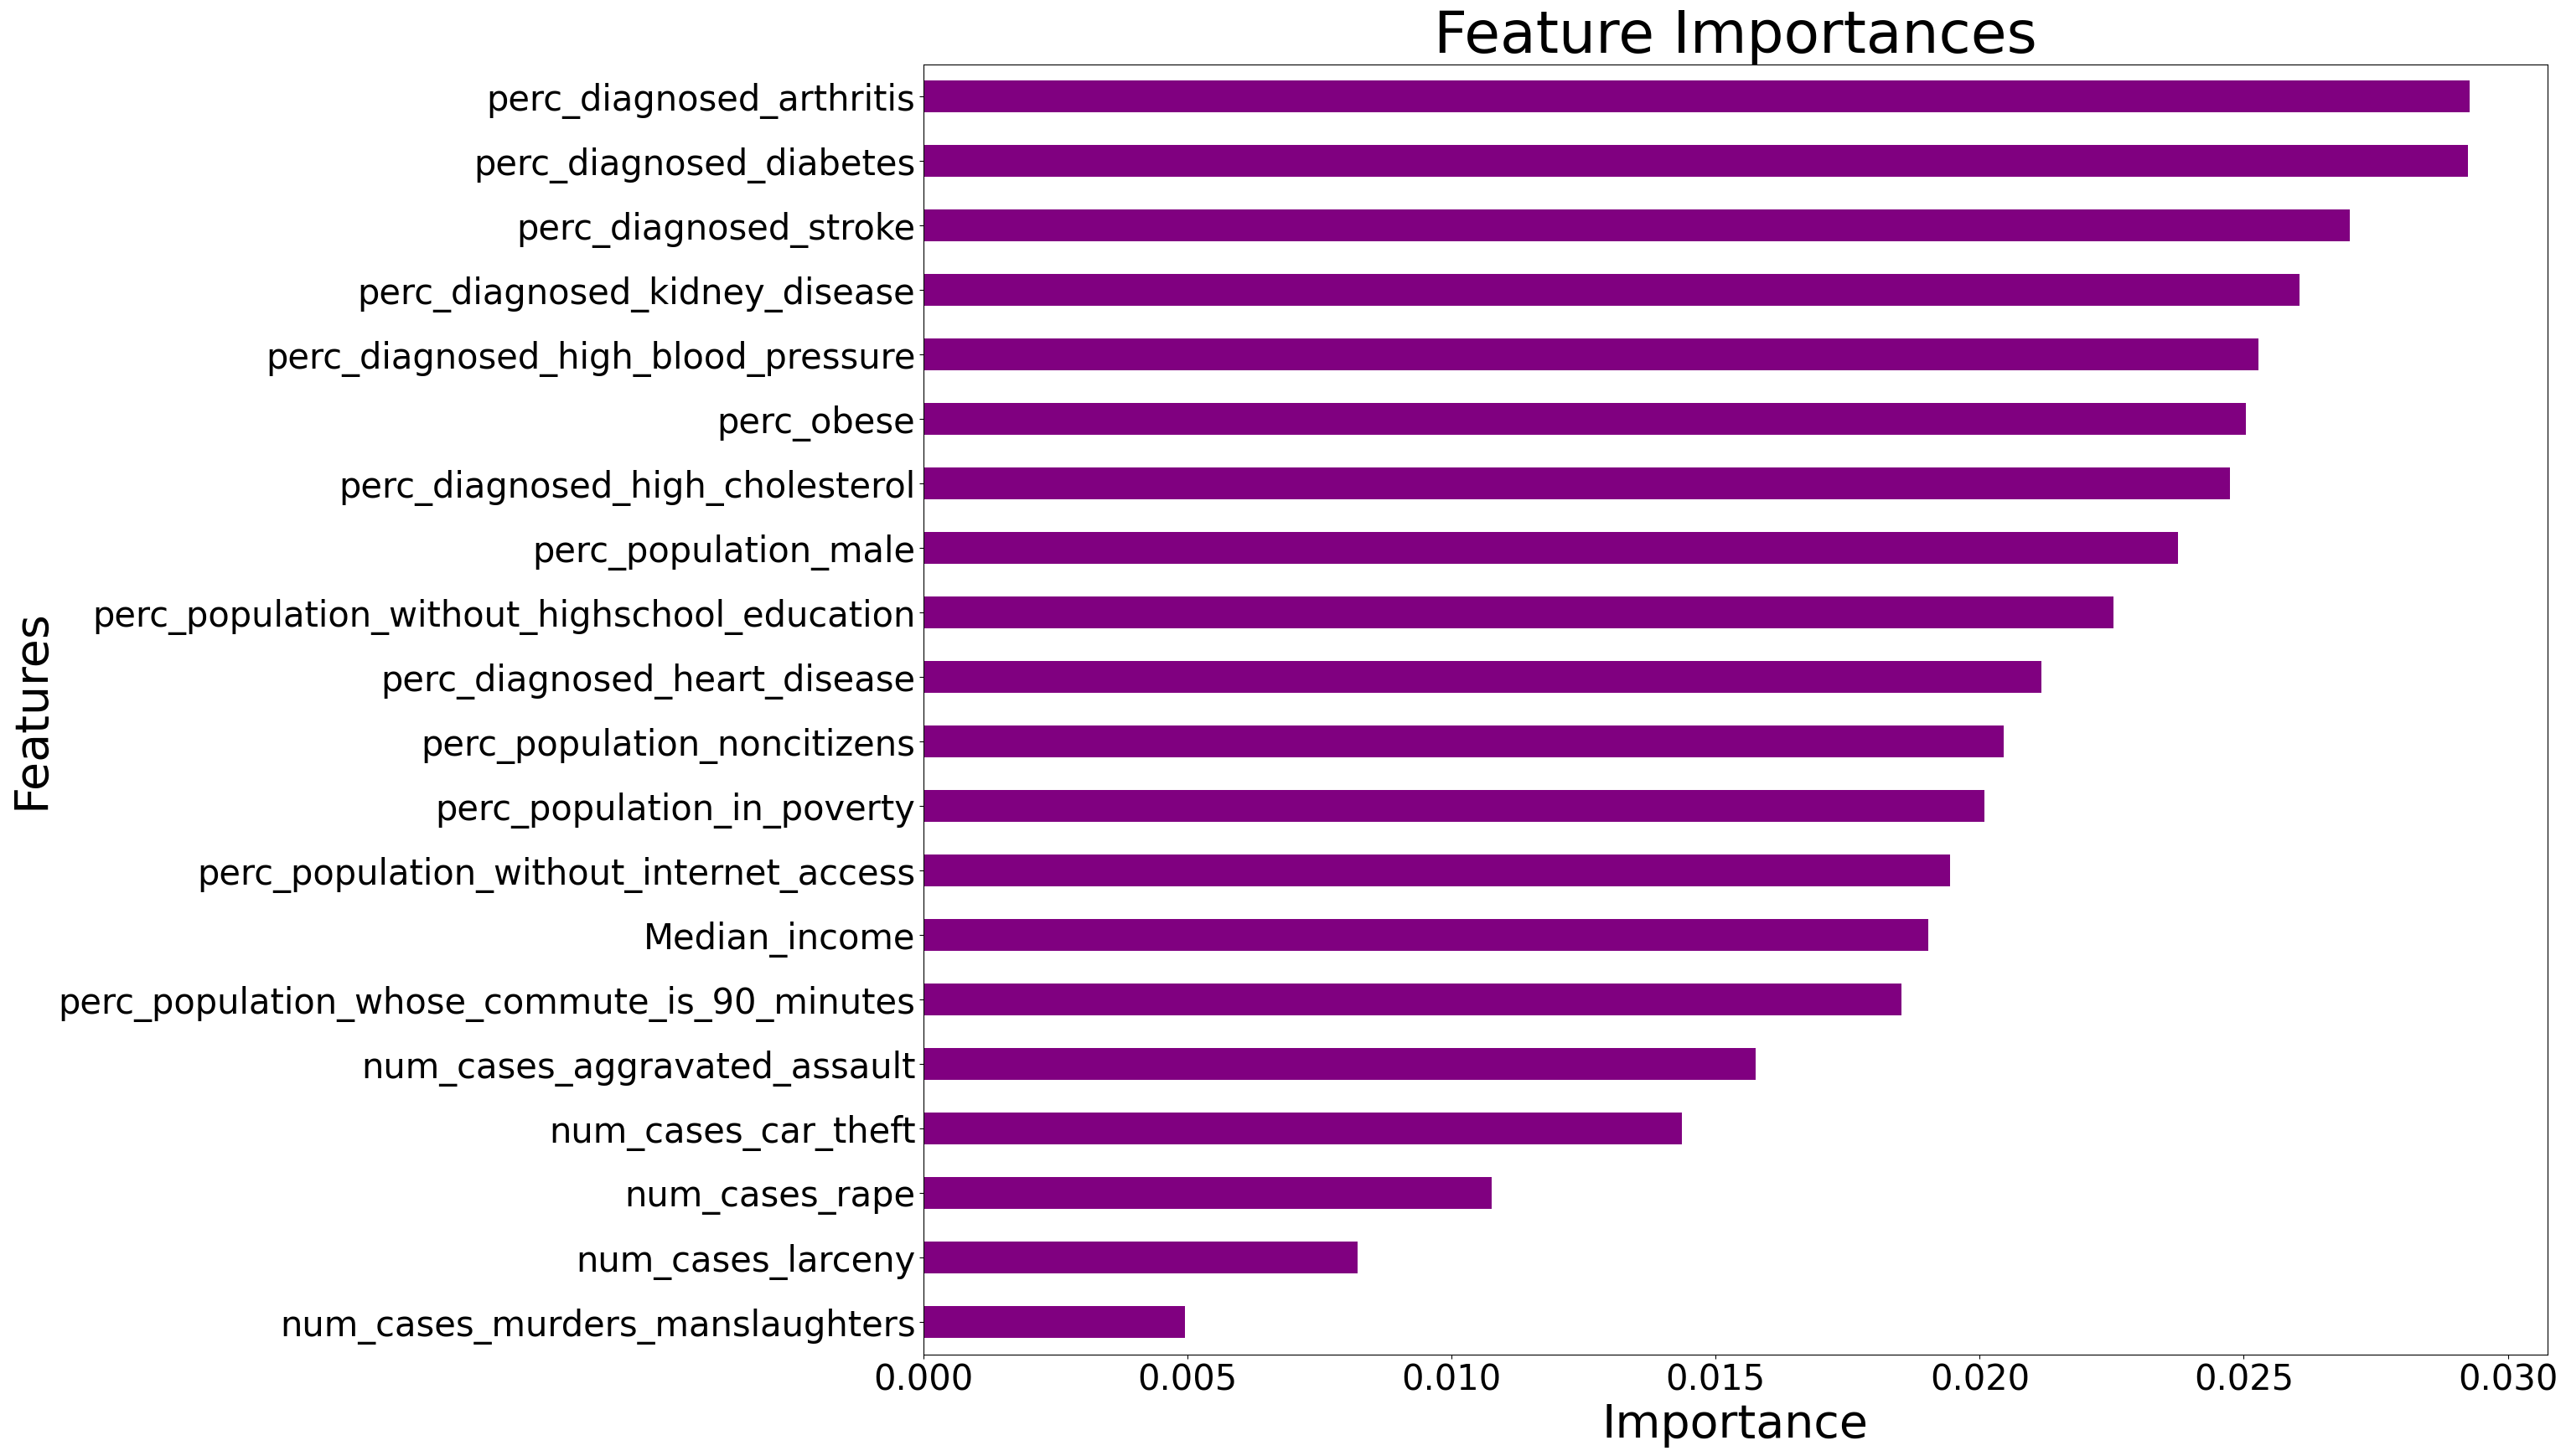

In [29]:
importances = pd.Series(data = rfbm.feature_importances_,
                        index = X_train.columns)

importances_sorted = importances.sort_values()
importances_sorted = importances_sorted.head(20)

fig = plt.figure(figsize = (25,20))
ax = importances_sorted.plot(kind='barh', color='purple')
plt.title('Feature Importances', fontsize=50)  # Title font size
plt.xlabel('Importance', fontsize=40)  # X-axis label font size
plt.ylabel('Features', fontsize=40)  # Y-axis label font size
ax.tick_params(axis='x', labelsize=30)  # X-axis tick label size
ax.tick_params(axis='y', labelsize=30)
plt.show

## AdaBoosting

In [30]:
start = time.time()
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3, 4, 5],
}
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(estimator = dt, algorithm = 'SAMME')
random_search = RandomizedSearchCV(estimator=ada, param_distributions=param_grid, n_iter=10, cv=5, random_state = 1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
end = time.time()
print(end-start)

Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.1, 'estimator__max_depth': 4}
198.0198278427124


Test Accuracy: 0.6351
0.6350974930362117


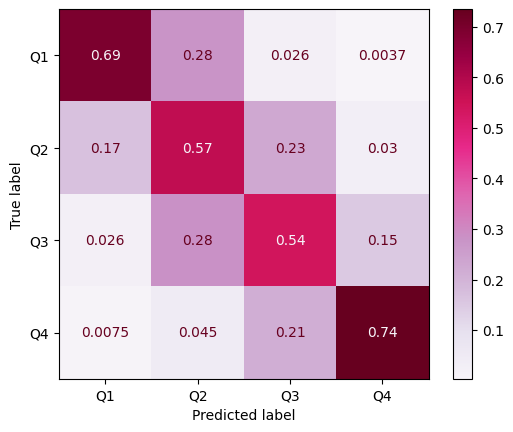

[[187  75   7   1]
 [ 45 153  61   8]
 [  7  77 147  41]
 [  2  12  57 197]]
              precision    recall  f1-score   support

          Q1       0.78      0.69      0.73       270
          Q2       0.48      0.57      0.52       267
          Q3       0.54      0.54      0.54       272
          Q4       0.80      0.74      0.77       268

    accuracy                           0.64      1077
   macro avg       0.65      0.64      0.64      1077
weighted avg       0.65      0.64      0.64      1077



In [31]:
adabm = random_search.best_estimator_
y_pred = adabm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred = adabm.predict(X_test)
adaacc = accuracy_score(y_test, y_pred)
print(adaacc)
ConfusionMatrixDisplay.from_estimator(adabm, X_test, y_test,
        cmap = plt.cm.PuRd, normalize = 'true')
plt.show()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

<function matplotlib.pyplot.show(close=None, block=None)>

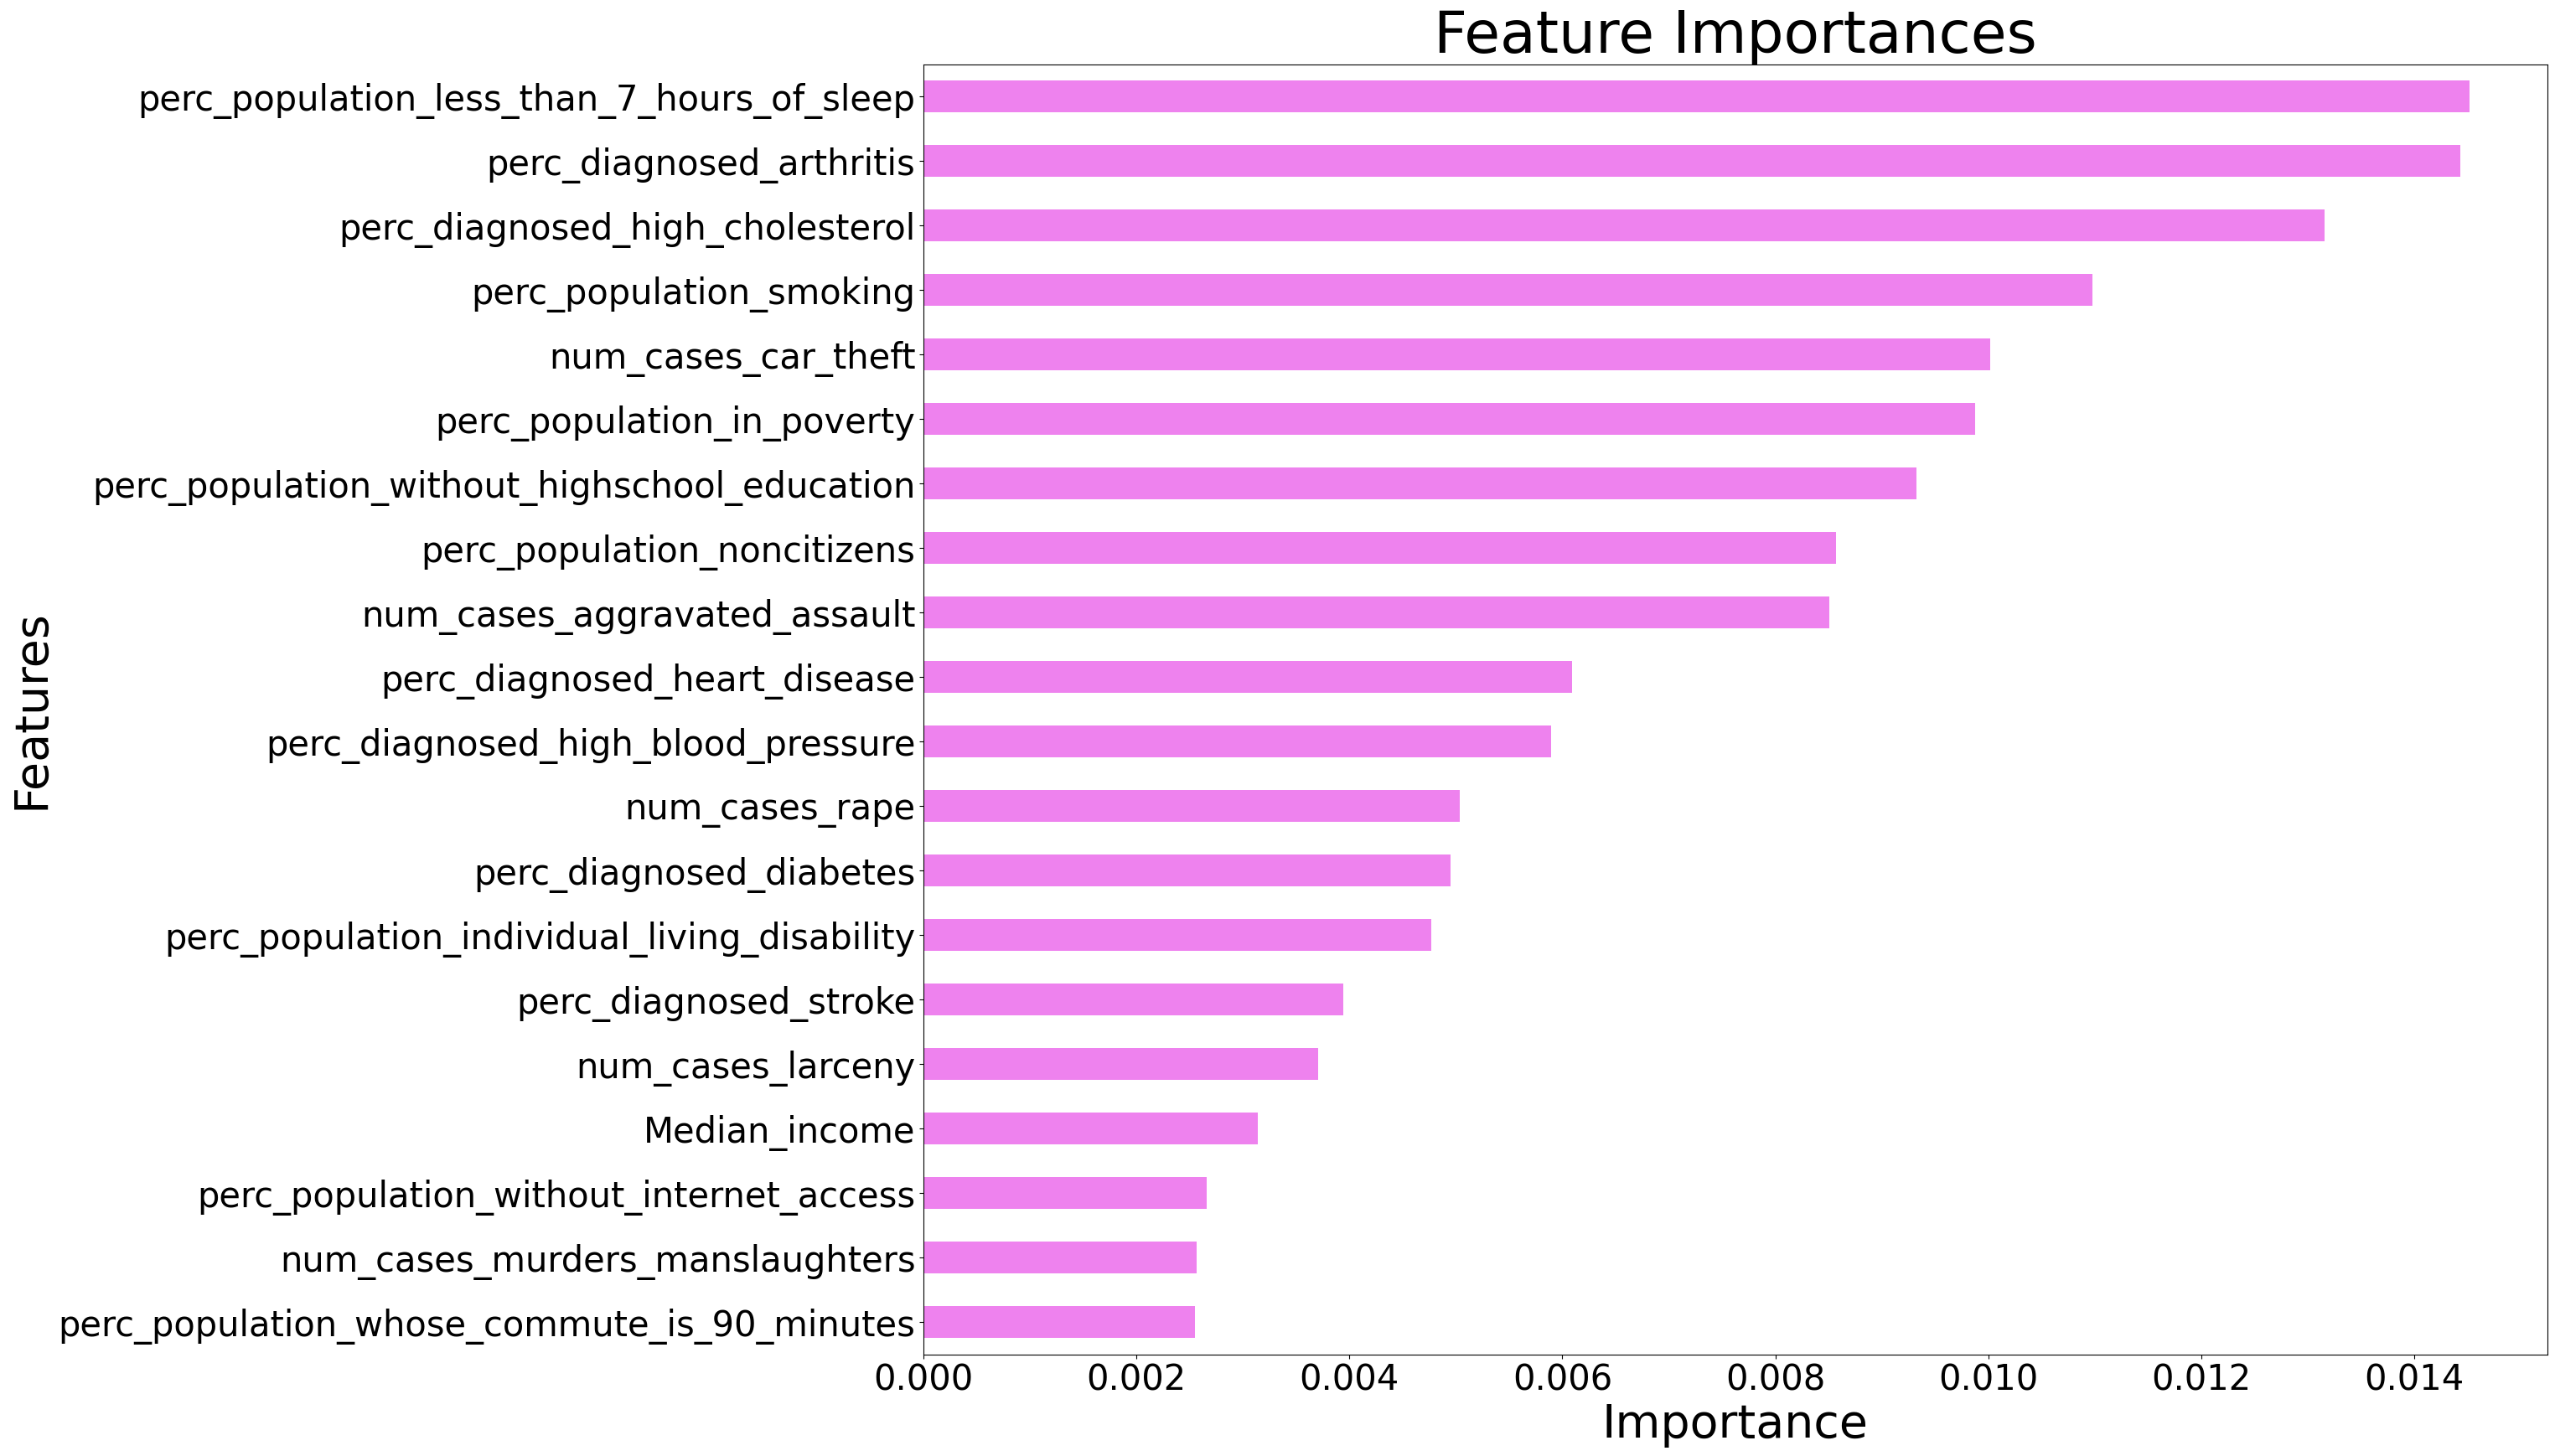

In [32]:
importances = pd.Series(data = adabm.feature_importances_,
                        index = X_train.columns)

importances_sorted = importances.sort_values()
importances_sorted = importances_sorted.head(20)

fig = plt.figure(figsize = (25,20))
ax = importances_sorted.plot(kind='barh', color='violet')
plt.title('Feature Importances', fontsize=50)  # Title font size
plt.xlabel('Importance', fontsize=40)  # X-axis label font size
plt.ylabel('Features', fontsize=40)  # Y-axis label font size
ax.tick_params(axis='x', labelsize=30)  # X-axis tick label size
ax.tick_params(axis='y', labelsize=30)
plt.show

In [33]:
missX = miss_data.drop(['Unnamed: 0', 'spatial_id', 'name', 'perc_population_with_depression'], axis=1)
missX_scaled = scaler.fit_transform(missX)
missX = pd.DataFrame(missX_scaled, columns=missX.columns)

Lastly, we assemble all of our predictions for the missing data into a dataframe. We use the "predmatcher" function to assemble our predictions from each of the models and align them with the names of the counties they correspond to. We then tally how many times the models predicted a certain outcome (in this case, whether the county had low, medium, or high rates of depression) before assessing which outcome was predicted the most in the "consensus" variable.

In [34]:
def predmatcher(model):
    x = list(model.predict(missX_scaled))
    namedpreds = []
    for i in range(0, len(x)):
        namedpreds.append(x[i])
    return namedpreds

In [35]:
modelpreds = pd.DataFrame({
    'County_Name':list(miss_data.name),
    f'logregpreds: {logregacc:.3f}':predmatcher(logregbm), 
    f'ldapreds: {ldaacc:.3f}':predmatcher(ldabm),
    f'NBpreds: {NBayesacc:.3f}':predmatcher(NBayes),
    f'knn: {knnacc:.3f}':predmatcher(knn),
    f'svcpreds: {svcacc:.3f}':predmatcher(svcbm),
    f'rfpreds: {rfacc:.3f}':predmatcher(rfbm),
    f'adapreds: {adaacc:.3f}':predmatcher(adabm),
    })
for i in ['Q1', 'Q2', 'Q3', 'Q4']:
    modelpreds[f'{i}_counts'] = modelpreds.apply(lambda row: (row == i).sum(), axis=1)
modelpreds['max'] = modelpreds[['Q1_counts', 'Q2_counts', 'Q3_counts', 'Q4_counts']].max(axis=1)
modelpreds['consensus'] = modelpreds.mode(axis=1)[0]
modelpredsPR = modelpreds[modelpreds['County_Name'].str.contains('PR')]
modelpredsFL = modelpreds[modelpreds['County_Name'].str.contains('FL')]

/tmp/ipykernel_194/2414733251.py:14: UserWarning:

Unable to sort modes: '<' not supported between instances of 'int' and 'str'

/tmp/ipykernel_194/2414733251.py:14: UserWarning:

Unable to sort modes: '<' not supported between instances of 'int' and 'numpy.str_'



Relative to the documentation on data in Florida, several data points in Puerto Rico are missing. For instance, there is no documentation on several health statistics for Puerto Rican counties. To facilitate analysis, therefore, the Puerto Rican counties are separated from the Floridian counties.

For 76 out of 78 Puerto Rican counties on file, only 2 were not deemed as having middling depression rates, Adjuntas Municipio, and Culebra Municipio.

In [36]:
modelpredsPR.head()

,County_Name,logregpreds: 0.690,ldapreds: 0.668,NBpreds: 0.413,knn: 0.609,svcpreds: 0.721,rfpreds: 0.683,adapreds: 0.635,Q1_counts,Q2_counts,Q3_counts,Q4_counts,max,consensus
0,"Cataño Municipio, PR",Q2,Q3,Q3,Q3,Q3,Q2,Q3,0,2,5,0,5,Q3
1,"Florida Municipio, PR",Q3,Q3,Q3,Q3,Q3,Q2,Q2,0,2,5,0,5,Q3
2,"Hormigueros Municipio, PR",Q1,Q1,Q3,Q3,Q3,Q2,Q2,2,2,3,0,3,Q3
3,"Trujillo Alto Municipio, PR",Q3,Q3,Q3,Q2,Q3,Q3,Q3,0,1,6,0,6,Q3
4,"Comerío Municipio, PR",Q2,Q3,Q3,Q3,Q2,Q2,Q3,0,3,4,0,4,Q3


In [37]:
modelpredsPR['consensus'].value_counts()

consensus
Q3    64
Q2    13
Q1     1
Name: count, dtype: int64

In [38]:
modelpredsPRQ = modelpredsPR[modelpredsPR['consensus'] != "Q2"]
modelpredsPRQ.head()

,County_Name,logregpreds: 0.690,ldapreds: 0.668,NBpreds: 0.413,knn: 0.609,svcpreds: 0.721,rfpreds: 0.683,adapreds: 0.635,Q1_counts,Q2_counts,Q3_counts,Q4_counts,max,consensus
0,"Cataño Municipio, PR",Q2,Q3,Q3,Q3,Q3,Q2,Q3,0,2,5,0,5,Q3
1,"Florida Municipio, PR",Q3,Q3,Q3,Q3,Q3,Q2,Q2,0,2,5,0,5,Q3
2,"Hormigueros Municipio, PR",Q1,Q1,Q3,Q3,Q3,Q2,Q2,2,2,3,0,3,Q3
3,"Trujillo Alto Municipio, PR",Q3,Q3,Q3,Q2,Q3,Q3,Q3,0,1,6,0,6,Q3
4,"Comerío Municipio, PR",Q2,Q3,Q3,Q3,Q2,Q2,Q3,0,3,4,0,4,Q3


## Analyzing Results: Florida

For Floridian counties, the SVC predicts an overwhelming majority in the the second quartile, and six counties in the first quartile. This means that, overall, 

In [39]:
modelpredsFL.head()

,County_Name,logregpreds: 0.690,ldapreds: 0.668,NBpreds: 0.413,knn: 0.609,svcpreds: 0.721,rfpreds: 0.683,adapreds: 0.635,Q1_counts,Q2_counts,Q3_counts,Q4_counts,max,consensus
77,"Union County, FL",Q2,Q2,Q2,Q2,Q2,Q3,Q3,0,5,2,0,5,Q2
78,"Gilchrist County, FL",Q3,Q2,Q3,Q3,Q2,Q3,Q3,0,2,5,0,5,Q3
79,"Seminole County, FL",Q3,Q3,Q3,Q3,Q2,Q3,Q3,0,1,6,0,6,Q3
80,"Hardee County, FL",Q2,Q2,Q3,Q3,Q2,Q3,Q3,0,3,4,0,4,Q3
81,"DeSoto County, FL",Q3,Q2,Q3,Q3,Q2,Q3,Q3,0,2,5,0,5,Q3


In [40]:
modelpredsFL['svcpreds: 0.721'].value_counts()

svcpreds: 0.721
Q2    61
Q1     6
Name: count, dtype: int64

In [46]:
modelpredsFLQ1 = modelpredsFL[modelpredsFL['svcpreds: 0.721'] == 'Q1']
modelpredsFLQ1.head(6)

,County_Name,logregpreds: 0.690,ldapreds: 0.668,NBpreds: 0.413,knn: 0.609,svcpreds: 0.721,rfpreds: 0.683,adapreds: 0.635,Q1_counts,Q2_counts,Q3_counts,Q4_counts,max,consensus
115,"Lee County, FL",Q3,Q3,Q1,Q3,Q1,Q3,Q3,2,0,5,0,5,Q3
122,"Orange County, FL",Q3,Q3,Q1,Q1,Q1,Q3,Q2,3,1,3,0,3,Q3
129,"Palm Beach County, FL",Q4,Q3,Q1,Q3,Q1,Q3,Q3,2,0,4,1,4,Q3
131,"Hillsborough County, FL",Q3,Q3,Q1,Q3,Q1,Q3,Q3,2,0,5,0,5,Q3
141,"Miami-Dade County, FL",Q1,Q3,Q1,Q1,Q1,Q3,Q2,4,1,2,0,4,Q1
143,"Escambia County, FL",Q3,Q2,Q1,Q3,Q1,Q3,Q3,2,1,4,0,4,Q3


In [43]:
modelpredsFL['consensus'].value_counts()

consensus
Q3    61
Q2     5
Q1     1
Name: count, dtype: int64

Pinellas, Manatee, and Collier County were predicted as having high rates of depression, while Orange and Miami-Dade county were predicted as having low rates of depression. Further research into what might make the former three counties at risk of high depression rates, and consequently what steps to take to ameliorate those circumstances, might prove valiable. On the other hand, learning from the examples that the latter two counties show may also be worthwhile.

In [44]:
modelpredsFLQ1 = modelpredsFL[modelpredsFL['consensus'] == 'Q1']
modelpredsFLQ1.head()

,County_Name,logregpreds: 0.690,ldapreds: 0.668,NBpreds: 0.413,knn: 0.609,svcpreds: 0.721,rfpreds: 0.683,adapreds: 0.635,Q1_counts,Q2_counts,Q3_counts,Q4_counts,max,consensus
141,"Miami-Dade County, FL",Q1,Q3,Q1,Q1,Q1,Q3,Q2,4,1,2,0,4,Q1
